In [1]:
%matplotlib inline
import numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy
def smooth2a(matrixIn,Nr,Nc):
    device = matrixIn.device
    matrixIn = matrixIn.cpu().numpy()
    [row,col] = matrixIn.shape
    eL = scipy.sparse.spdiags(numpy.ones((2*Nr,row)),numpy.arange(-Nr,Nr),row,row)
    eR = scipy.sparse.spdiags(numpy.ones((2*Nc,col)),numpy.arange(-Nc,Nc),col,col)
    nrmlize = eL@(numpy.ones_like(matrixIn))@eR
    matrixOut = eL@matrixIn@eR
    matrixOut = matrixOut/nrmlize
    matrixOut = torch.from_numpy(matrixOut)
    matrixOut = matrixOut.to(device)
    return matrixOut
def norm_trace(seis):
    data_out = np.zeros(np.shape(seis))
    for k in range(np.size(seis,axis=1)):
        data_out[:,k] = seis[:,k]/np.max(np.abs(seis[:,k]))
    seis=data_out
    return seis
def envelope(xr):
    for i in range(np.size(xr,axis=1)):
        hx = fftpack.hilbert(xr[:,i])
        xr[:,i] = np.sqrt(np.power(xr[:,i],2) + np.power(hx,2))
    return xr
def imagesc(damp,alpha=1,cmin=1,cmax=1):
    damp = damp.detach().cpu().numpy()
    if cmin == cmax:
        cmin=numpy.min(damp)
        cmax=numpy.max(damp)
    fig = plt.figure(facecolor=[0, 32/255, 96/255],figsize=(12,6))
    plt.pcolormesh(damp, vmin=cmin, vmax=cmax,cmap= 'jet')
    ax = plt.gca() 
    ax.invert_yaxis() 
    plt.tick_params(axis='x',colors='w')
    plt.tick_params(axis='y',colors='w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
#     plt.xlabel("step",fontsize=20)
#     plt.ylabel("rate",fontsize=20)
    cb=plt.colorbar(pad=0.03)
    cb.ax.tick_params(colors='w',labelsize=18)
    cb.ax.spines['right'].set_color('w')
    matplotlib.cm.get_cmap('jet')
def extend_wave(s,nt):
    ng = np.size(s,axis=1)
    if np.size(s[:,0])<nt:
        ss=np.zeros((nt,ng))
        for i in range(ng):
            xr=np.zeros((nt))
            xr[0:np.size(s[:,0])]=s[:,i]
            ss[:,i]=xr
    return ss
def pad(p0, nbc, pad_top):
    p=torch.cat((p0[:,0].reshape(-1,1).repeat(1,nbc),p0,p0[:,-1].reshape(-1,1).repeat(1,nbc)),dim=1)
    p=torch.cat((p[0,:].reshape(1,-1).repeat(pad_top,1),p,p[-1,:].reshape(1,-1).repeat(nbc,1)),dim=0)
    return p
import scipy.io as sio
import torch
from torch.utils.data import DataLoader
import time

In [2]:
import torch
#import visdom
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn, optim

import scipy.io as sio

class NN1(nn.Module):
    def __init__(self, num_input, w0, h0, vmax, vmin):
        super(NN1, self).__init__()
        self.net1 = nn.Sequential(
            nn.Linear(num_input, w0*h0*8,bias=False),        
            nn.ReLU(),
        )
    
        self.net2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 128, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 64, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 32, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(32, 16, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(16, 8, (4, 4), stride=(1, 1), padding="same", bias=False),
#             nn.LeakyReLU(negative_slope=0.01),
            
            nn.Conv2d(16, 1, (4, 4), stride=(1, 1), padding="same", bias=False),
            
        )
    def forward(self, x):
        
        x = self.net1(x)
        x = x.reshape(-1, int(num_input), int(w0), int(h0))
        x = self.net2(x)
        return x
    
class NN2(nn.Module):
    def __init__(self, num_input, w0, h0, vmax, vmin):
        super(NN2, self).__init__()
        self.net1 = nn.Sequential(
            nn.Linear(num_input, w0*h0*8,bias=False),        
            nn.ReLU(),
        )
    
        self.net2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 128, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(128),
#             nn.Dropout2d(p=0.35),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 64, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#             nn.Dropout2d(p=0.40),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 32, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(p=0.35),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(32, 16, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(16),
#             nn.Dropout2d(p=0.30),
            
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(16, 8, (4, 4), stride=(1, 1), padding="same", bias=False),
#             nn.LeakyReLU(negative_slope=0.01),
            
            nn.Conv2d(16, 1, (4, 4), stride=(1, 1), padding="same", bias=False),
            
        )
    def forward(self, x):
        
        x = self.net1(x)
        x = x.reshape(-1, int(num_input), int(w0), int(h0))
        x = self.net2(x)
        return x

In [3]:
class NN3(nn.Module):
    def __init__(self, num_input, w0, h0, vmax, vmin):
        super(NN3, self).__init__()
        self.net1 = nn.Sequential(
            nn.Linear(num_input, w0*h0*8,bias=False),        
            nn.ReLU(),
        )
    
        self.net2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 64, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 32, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(32, 16, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 1, (4, 4), stride=(1, 1), padding="same", bias=False),
#             nn.LeakyReLU(negative_slope=0.01),
            
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(16, 8, (4, 4), stride=(1, 1), padding="same", bias=False),
#             nn.LeakyReLU(negative_slope=0.01),
            
#             nn.Conv2d(16, 1, (4, 4), stride=(1, 1), padding="same", bias=False),
            
        )
    def forward(self, x):
        
        x = self.net1(x)
        x = x.reshape(-1, int(num_input), int(w0), int(h0))
        x = self.net2(x)
        return x
    

In [4]:
import torch.nn.functional as F
def staggeredfd_py_cuda(
    inputs,
    temp,
    ca,       
    cl,       
    cm,       
    cm1,        
    b,      
    b1,      
    s):
    nt = int(inputs[0])
    nzbc = int(inputs[1])
    nxbc = int(inputs[2])
    dtx = float(inputs[3])
    ng = int(inputs[4])
    sz = int(inputs[5]);sz = sz - 1;
    sx = int(inputs[6]);sx = sx - 1;
    gz = int(inputs[7]);gz = gz - 1;
    gx = int(inputs[8]);gx = gx - 1;
    dg = int(inputs[9])
    source_type_num = int(inputs[10])
    fd_order_num = int(inputs[11])
    number_elements = nt*ng
    length_geophone = ng*dg
    nt_interval = int(inputs[12])
    nz = int(inputs[13])
    nx = int(inputs[14])
    format_num = int(inputs[15])
    nbc = (nxbc-nx)/2
    num_nt_record = nt//nt_interval
    wavefield_elements = num_nt_record*nx*nz


    #   Input variables from python numpy: temp ca cl cm b s
    # libtorch Initialising input variables: uu, ww, xx, xz, zz
    uu = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    ww = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    zz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising input variables: fux, fuz, bwx, bwz
    fux = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    fuz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising output variables: seismo_w, seismo_u       
    seismo_w = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))
    seismo_u = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))

    wavefield_gradient_fux = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_fuz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwx = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))

    #  libtorch zero_vector for free surface zz
    zero_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    geophone_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))

    if fd_order_num==22 :
        k = nzbc-2; i = nxbc-2; pad_top = 1;
    elif fd_order_num==24 :
        k = nzbc-4; i = nxbc-4; pad_top = 2;
    elif fd_order_num==26 :
        k = nzbc-6; i = nxbc-6; pad_top = 3;
    elif fd_order_num==28 :
        k = nzbc-8; i = nxbc-8; pad_top = 4;
    S41 = 1.1250;S42 = -0.0416666667;S61 = 1.17187;S62 = -6.51042E-2;S63 = 4.68750E-3;S81 = 1.19629;S82 = -7.97526E-2;S83 = 9.57031E-3;S84 = -6.97545E-4;

    for it in range(nt) :
        if  fd_order_num == 22 :
            uu = F.pad((temp[1:1+k, 1:1+i]*(uu[1:1+k, 1:1+i]) + b[1:1+k, 1:1+i]*(  \
                    xx[1:1+k, 1+1:1+1+i] - xx[1:1+k, 1:1+i] + xz[1:1+k, 1:1+i] - xz[1-1:1-1+k, 1:1+i])), [1, 1, 1, 1])   
            ww = F.pad((temp[1:1+k, 1:1+i]*(ww[1:1+k, 1:1+i]) + b1[1:1+k, 1:1+i]*(  \
                    xz[1:1+k, 1:1+i] - xz[1:1+k, 1-1:1-1+i] + zz[1+1:1+1+k, 1:1+i] - zz[1:1+k, 1:1+i])), [1, 1, 1, 1])         
        
        if source_type_num == 3:
            uu[sz,sx] = uu[sz,sx] + s[it]
            ww[sz,sx] = ww[sz,sx] + s[it]
        elif source_type_num == 5:
            ww[sz,sx]=s[it]    
            
        if fd_order_num == 22 :
            fux = F.pad((uu[1:1+k, 1:1+i] - uu[1:1+k, 1-1:1-1+i]), [1, 1, 1, 1])   
            fuz = F.pad((uu[1+1:1+1+k, 1:1+i] - uu[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwx = F.pad((ww[1:1+k, 1+1:1+1+i] - ww[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwz = F.pad((ww[1:1+k, 1:1+i] - ww[1-1:1-1+k, 1:1+i]), [1, 1, 1, 1])   
            
        xx=temp * (xx) + (ca * (fux) + cl * (bwz))*dtx
        zz=temp * (zz) + (ca * (bwz) + cl * (fux))*dtx
        xz=temp * (xz) + (cm1 * (fuz + bwx))*dtx

#         zz[pad_top,:]=0.0

        seismo_w[it, :] = (1+0*torch.randn((1,ng),device=torch.device('cuda', 0))) * ww[gz,gx:gx+length_geophone-1:dg]

        seismo_u[it, :] = (1+0*torch.randn((1,ng),device=torch.device('cuda', 0))) * uu[gz,gx:gx+length_geophone-1:dg]
#         if(it%nt_interval==0):
#             wavefield_gradient_fux[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fux[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_fuz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fuz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwx[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwx[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]  


    return seismo_u,seismo_w

In [5]:
import libtorch_staggerfd_cuda

In [6]:
model_list = sio.loadmat('wadi_init.mat')
vp_RM = torch.from_numpy(model_list['vp_init'].astype('float32'))
# vp_RM = vp_RM[0:40,:]
# vp_RM = torch.from_numpy(model30[0][0][0].astype('float32'))
# vp_RM = torch.from_numpy(model3.astype('float32'))
# vs_RM = torch.div(vp_RM,model37)
wadid = sio.loadmat('wadi_data4.mat')
source = torch.from_numpy(wadid['nsource'].astype('float32')).to('cuda')
s = source
seismo_v_d = torch.from_numpy(wadid['wadi_interp'].astype('float32')).to('cuda')
# udlimit = sio.loadmat('udlimit.mat')
p_ind = torch.from_numpy(wadid['p_ind'].astype('float32'))
# nt = torch.from_numpy(wadid['nt'].astype('int64'))
nt=6000
vp_RM = vp_RM#[:50,:]                  
vs_RM = vp_RM/1.732
[nz,nx]=vp_RM.shape  #nz：深度网格点数，nx测线方向网格点数
nbc=40                  #吸收边界长
dx=1                    #一网格点对应深度
dt=1.25e-4
# nt=torch.floor(nx*dx/torch.min(vp_RM)/dt+300) #公式，不能过短

fr=30              #频率
isfs=1
nbc = 40
if isfs == 1:
    pad_top = 2
else:
    pad_top = nbc
ds=2
sx=torch.arange(0,nx-2,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=2
gx=torch.arange(0,nx-2,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1
sx=sx+nbc
sz=sz+pad_top-1
gx=gx+nbc
gz=gz+pad_top-1


In [13]:
len(sx)

117

torch.Size([71, 235])

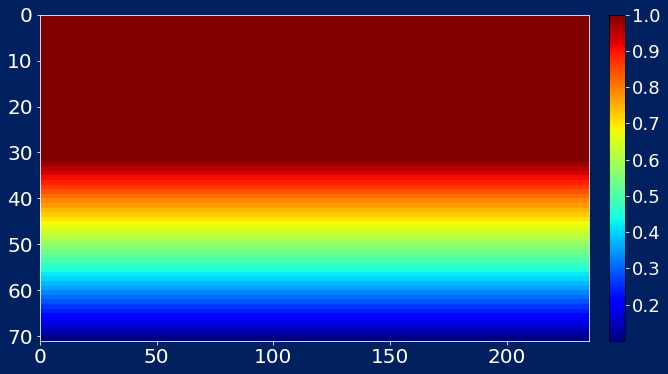

In [7]:
asd = torch.cat((torch.ones((31,1)),torch.linspace(1,0.1,40).view(-1,1)),0)
vs_de = asd.repeat(1,nx)
imagesc(vs_de)
vs_de.shape

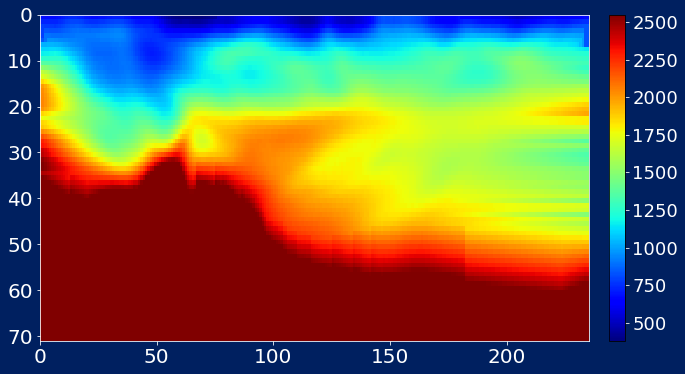

In [8]:
imagesc(vp_RM)

In [9]:
x = torch.rand(size=(1, 8)).requires_grad_(True)
vpmax=torch.max(vp_RM)*1.5
vpmin=torch.min(vp_RM)
vsmax=torch.max(vs_RM)*1.4
vsmin=torch.min(vs_RM)*0.9
[nz,nx] = vp_RM.shape
asd = torch.linspace(vpmin,vpmax,nz).view(-1,1)
vp0 = vp_RM
# vp0 = torch.from_numpy(model_list['vp_init'].astype('float32'))#ratio model require
asd = torch.linspace(vsmin,vsmax,nz).view(-1,1)
# vs0 = asd.repeat(1,nx)
vs0 = vs_RM
num_layer=4
num_input = 8
w0=int(np.ceil(vp0.shape[0]/(2**num_layer)))
h0=int(np.ceil(vp0.shape[1]/(2**num_layer)))
torch.set_printoptions(precision=10)
maxlinep = vpmax*torch.ones_like(vp0)
minlinep = vpmin*torch.ones_like(vp0)
maxlines = vsmax*torch.ones_like(vs0)
minlines = vsmin*torch.ones_like(vs0)
print('maxlinep',maxlinep[0,0],'minlinep',minlinep[0,0],'maxlines',maxlines[0,0],'minlines',minlines[0,0])

maxlinep tensor(3822.3818359375) minlinep tensor(380.6489562988) maxlines tensor(2059.7900390625) minlines tensor(197.7967987061)


In [10]:
dt

0.000125

In [11]:
sio.savemat('matinverarg.mat',{'vmin':float(vsmin),'nzbc':nz+pad_top+nbc,'nxbc':nx+nbc+nbc, \
            'dx':dx,'isfs':1,'pad_top':pad_top,'f':fr,'dt':float(dt),'nt':nt,'nbc':nbc})

In [12]:
def damp_circle(vmin,nzbc,nxbc,nbc,dx,isfs,pad_top):
    nz=nzbc-nbc-pad_top
    nx=nxbc-2*nbc

    a=(nbc-1)*dx
    kappa = 3.0 * vmin * 16.118095650958320 / (2.0 * a)

    # setup 1D BC damping array
    damp1d=kappa*(torch.arange(0,nbc)*dx/a)**2
    damp=torch.zeros((nzbc,nxbc))


# Take care of the 4 boundaries
   # Left and right
    for iz in range(pad_top,nz+pad_top):
        damp[iz,:nbc]=torch.flip(damp1d,[0])
        damp[iz,nx+nbc:nx+2*nbc]=damp1d


    for ix in range(nbc,nx+nbc):
        if (isfs):
            damp[0:pad_top,ix]=0.0
        else:
            damp[:pad_top,ix]=torch.flip(damp1d,[0])
        damp[nzbc-nbc:nzbc,ix]=damp1d

    # Take care of the 4 corners
        # Upper left
    if (~isfs):
        for iz in range(pad_top):
            for ix in range(nbc):
                dist=math.sqrt((ix-nbc-1)**2+(iz-pad_top-1)**2)
                damp[iz,ix]=kappa*(dist/nbc)**2

         # Upper right
        for iz in range(pad_top):
            for ix in range(nx+nbc,nxbc):
                dist=math.sqrt((ix-nx-nbc)**2+(iz-pad_top-1)**2)
                damp[iz,ix]=kappa*(dist/nbc)**2

   
       # Lower left
    for iz in range(nz+pad_top,nzbc):
        for ix in range(nbc):
            dist=math.sqrt((ix-nbc)**2+(iz-nz-pad_top)**2)
            damp[iz,ix]=kappa*(dist/nbc)**2
       # Lower right
    for iz in range(nz+pad_top,nzbc):
        for ix in range(nx+nbc,nxbc):
            dist=math.sqrt((ix-nbc-nx)**2+(iz-nz-pad_top)**2)
            damp[iz,ix]=kappa*(dist/nbc)**2

    return damp

damp=damp_circle(vsmin,nz+pad_top+nbc,nx+nbc+nbc,nbc,dx,1,pad_top)
temp = 1-damp*dt


In [13]:
#!matlab -nojvm -nodesktop -nosplash -r matinter

In [14]:
!ls matinvertemp.mat -l

-rw-rw-r-- 1 user user 35920 Feb 24 18:58 matinvertemp.mat


In [15]:
# dummy_input = sio.loadmat('matinvertemp.mat')
# for dummy_input_key in list(dummy_input.keys())[3:4]:
#     print(dummy_input_key)
#     exec(dummy_input_key + '=dummy_input["' + dummy_input_key + '"].astype(np.float32)')
#     exec(dummy_input_key + '=torch.from_numpy(' + dummy_input_key + ').to("cuda")')

In [16]:
torch.__version__

'1.12.0+cu116'

In [17]:

dtx = float(dt/dx)
den = pad(torch.ones((nz,nx)),nbc,pad_top)
vp1 = pad(vp0,nbc,pad_top)
vs1 = pad(vs0,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
# temp = pad(temp,nbc,pad_top)

# den[0:pad_top,:] = 0.5*den[0:pad_top,:]
den1=den
# den1[pad_top-1,:]=2*den1[pad_top-1,:]
# cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm;
# cl[0:pad_top-1,:]=0.0;
# cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 5
fd_order_num = 22
in_wf = 1
format_num = 2
# input_vector: [nt,nzbc,nxbc,dtx,ng,sz,sx,gz(1),gx(1),gx(2)-gx(1),source_type_num,fd_order_num,in_wf,nz,nx,format_num];


In [18]:
input_vector = torch.tensor([nt,nzbc,nxbc,dtx,ng,int(sz[0]),int(sx[0]),int(gz[0]),int(gx[0]),int(gx[1]-gx[0]), \
                             source_type_num,fd_order_num,in_wf,nz,nx,format_num])

In [19]:
nz

71

In [20]:
model1 = NN1(8, w0, h0, vpmax, vpmin)
model2 = NN2(8, w0, h0, vsmax, vsmin)

In [21]:
for le in ['vp_RM','vs_RM','s','sx','sz','gx','gz','x','vp1 ','maxlinep','minlinep','maxlines','minlines', \
           'vs1','den','input_vector','temp','vp0','vs0','vs_de']:
    print(le)
    exec(le + '=' + le + '.to("cuda:0")')
model1.to("cuda:0")
model2.to("cuda:0")

vp_RM
vs_RM
s
sx
sz
gx
gz
x
vp1 
maxlinep
minlinep
maxlines
minlines
vs1
den
input_vector
temp
vp0
vs0
vs_de


NN2(
  (net1): Sequential(
    (0): Linear(in_features=8, out_features=600, bias=False)
    (1): ReLU()
  )
  (net2): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(8, 128, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
  )
)

In [22]:
def GW_mute(seismo_w,T1,gx,sx,T0,vg,dt,ztr):
# zoffset_mask = mute_near_offset(seismo_w,gx-sx,ztr)
    device = seismo_w.device
    tau_o = T0 + torch.ceil(torch.abs(gx-sx)/vg/dt)
    [nt,ng] = seismo_w.shape
    tapering = torch.ones((nt,ng), device = device)
    sig = 0.05* T1
    for k in range(ng):
        b2 = tau_o[k]
        for j in range(nt):
            if j> b2:
                tapering[j,k] = torch.exp((-(j-b2)**2)/(2*(sig**2)))
    seismo_w_mute = seismo_w*(tapering) 
    return seismo_w_mute

# def mute_near_offset(input1,h,lamba):
# output=torch.ones_like(input1)
# dh=h[2]-h[1];
# idh=torch.abs(h/dh);
# [~,ix2]=find(idh==lamba)
# if ~isempty(ix2)
#     for ix=1:length(h)
#         if (idh[ix]<=lamba)
#            output[:,ix]=0

# return output
def bp_filter(d,dt,f1,f2,f3,f4):
    device = d.device
    [nt,nx] = d.shape
    k = torch.ceil(torch.log2(torch.tensor([nt])))
    nf = int(4*(2**k))

    i1 = int(math.floor(nf*f1*dt)+1)
    i2 = int(math.floor(nf*f2*dt)+1)
    i3 = int(math.floor(nf*f3*dt)+1)
    i4 = int(math.floor(nf*f4*dt)+1)

    up =  torch.arange(1,i2-i1+1, device = device).reshape(1,-1)/(i2-i1)
    down = torch.arange(i4-i3,0,-1, device = device).reshape(1,-1)/(i4-i3)
    aux = torch.cat([torch.zeros((1,i1), device = device), up, torch.ones((1,i3-i2), device = device),  \
                     down, torch.zeros((1,nf//2+1-i4), device = device)],1) 
    aux2 = torch.flip(aux[:,0:nf//2-1],[1])

    c = 0
    F = torch.transpose(torch.cat([aux,aux2],1), 0, 1)
    Phase = (math.pi/180.)*torch.cat([torch.tensor([0], device = device).reshape(1,-1),-c*torch.ones((1,nf//2-1),device = device),  \
                                        torch.tensor([0], device = device).reshape(1,-1),c*torch.ones((1,nf//2-1), device = device)],1)
    Transfer = F*torch.exp(-1j*torch.transpose(Phase, 0, 1))
    Transfer = Transfer.reshape(nf)

    D = torch.fft.fft(d,nf,0)
    Do = torch.zeros_like(D,device = device)
    for k in range(nx):
        Do[:,k] = Transfer*D[:,k]


    o = torch.fft.ifft(Do,nf,0)

    o = torch.real(o[0:nt,:])
    return o
def manual_pick(seis,dt,i,ng,p_ind):
    device = seis.device
    mask = torch.ones_like(seis, device=device)
    for ii in range(ng):
        if ii!=i:
            mask[0:int(torch.round(p_ind[ii,i,0])),ii] = 0 
        mask[int(torch.round(p_ind[ii,i,1])):,ii] = 0 
    seis = seis * mask
    return seis

In [23]:
denm05 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm05[0:pad_top,:] = 0.5*denm05[0:pad_top,:]

denm2 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm2[pad_top-1,:]=2*denm2[pad_top-1,:]

denm0 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denm0[pad_top-1,:]=0.0;

denmp5 = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
denmp5[pad_top-1,:] = 0.5*denmp5[pad_top-1,:]


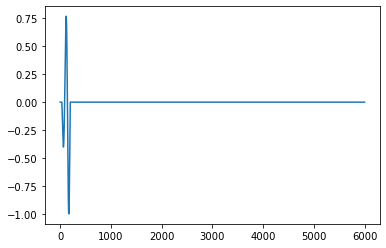

In [24]:
plt.plot(source.cpu().numpy())

In [25]:
def p_real_data(fmax):
    seismo_v_d = torch.from_numpy(wadid['wadi_interp'].astype('float32')).to('cuda')
    for jj in range(ns):
        seismo_v_d[:,:,jj] = bp_filter(seismo_v_d[:,:,jj],dt,5-5,5,fmax,fmax+5)
#         seismo_v_d[:,:,jj] = manual_pick(seismo_v_d[:,:,jj],dt,jj,ng,p_ind)
        for ii in range(ng):
            seismo_v_d[:,ii,jj] = seismo_v_d[:,ii,jj]/torch.max(torch.abs(seismo_v_d[:,ii,jj]))
    return seismo_v_d

In [26]:
vvpmax = vpmax-vpmin
vvpmin = vpmin-vpmax
((vvpmax - vvpmin) * np.array([-1,1]) + (vvpmax + vvpmin))/2.0
vvsmax = vsmax-vsmin
vvsmin = vsmin-vsmax
((vvsmax - vvsmin) * np.array([-1,1]) + (vvsmax + vvsmin))/2.0

tensor([-1861.9932861328,  1861.9932861328], dtype=torch.float64)

In [27]:
criteon = nn.MSELoss()
from itertools import chain
optimizer = optim.Adam(params=chain(model1.parameters(),model2.parameters()),lr=1e-4)
# optimizer = optim.Adam(model.parameters(),lr = 1e-3)
# optimizer = optim.Adagrad(model.parameters())

In [28]:
# pretrained_weights = torch.load('./lowvel2vp.pth')
# model1.load_state_dict(pretrained_weights)
# pretrained_weights = torch.load('./lowvel2vs.pth')
# model2.load_state_dict(pretrained_weights)

In [29]:
torch.autograd.set_detect_anomaly(False)

In [30]:
# from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
# criteon = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
import copy
torch.set_printoptions(precision=50)
print(x)
torch.set_printoptions(precision=10)

tensor([[0.10539638996124267578125000000000000000000000000000,
         0.56030684709548950195312500000000000000000000000000,
         0.31484299898147583007812500000000000000000000000000,
         0.50847834348678588867187500000000000000000000000000,
         0.14395523071289062500000000000000000000000000000000,
         0.49034613370895385742187500000000000000000000000000,
         0.34488910436630249023437500000000000000000000000000,
         0.94648641347885131835937500000000000000000000000000]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)


In [31]:
import math
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv2d') != -1:
#         fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
#         bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#         torch.nn.init.kaiming_uniform_(m.weight.data,a=math.sqrt(50))
        torch.nn.init.xavier_normal_(m.weight.data)
#         torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
#         fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
#         bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#         torch.nn.init.kaiming_uniform_(m.weight.data,a=math.sqrt(50))
#         torch.nn.init.uniform_(m.bias.data, -bound, bound)
        torch.nn.init.xavier_normal_(m.weight.data)
model1.apply(weights_init)
model2.apply(weights_init)

NN2(
  (net1): Sequential(
    (0): Linear(in_features=8, out_features=600, bias=False)
    (1): ReLU()
  )
  (net2): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(8, 128, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
  )
)

In [32]:
model1.eval()
model2.eval()
with torch.no_grad():
    yp = model1(x)
    ##update
    yp = ((vvpmax - vvpmin) * torch.tanh(yp) + (vvpmax + vvpmin))/2.0
    yp_ini = torch.squeeze(yp)
    ys = model2(x)
    ys = ((vvsmax - vvsmin) * torch.tanh(ys) + (vvsmax + vvsmin))/2.0
    ys_ini = torch.squeeze(ys)
model1.train()
model2.train()

/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


NN2(
  (net1): Sequential(
    (0): Linear(in_features=8, out_features=600, bias=False)
    (1): ReLU()
  )
  (net2): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(8, 128, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
  )
)

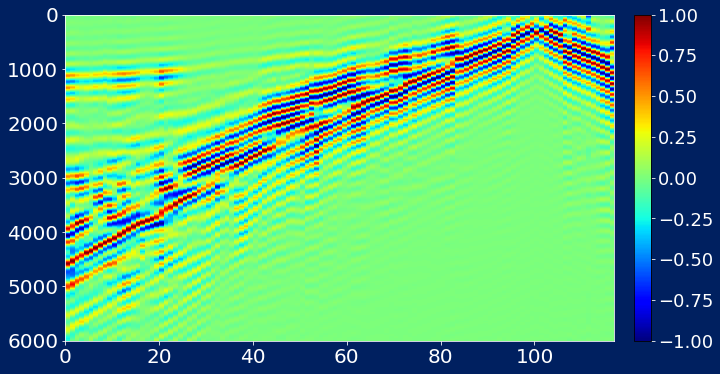

In [33]:
print_log = open("./wadi_0411.txt",'w')
iteration = 1200
device=('cuda')
res = torch.zeros((iteration), device='cuda')
res[0]=1
fmax = 40
seismo_v_d = p_real_data(fmax)
imagesc(seismo_v_d[:,:,100])
pur=0.05

In [ ]:
for i in range(1,iteration):
    T1=time.time()
    optimizer.zero_grad()
    for gg in range(0,ns,3):
#     for gg in range(ns):  
        yp = model1(x)
        yp = ((vvpmax - vvpmin) * torch.tanh(yp) + (vvpmax + vvpmin))/2.0
        yp = torch.squeeze(yp)
        y_shape0 = (yp.shape[0] - vp0.shape[0])//2
        y_shape1 = (yp.shape[1] - vp0.shape[1])//2
        dk_vp = yp[y_shape0:y_shape0+vp0.shape[0],y_shape1:y_shape1+vp0.shape[1]]
        v_mean_p=torch.sqrt(torch.sum(vp0**2))
        g_mean_p=torch.sqrt(torch.sum(dk_vp**2))
        alpha_p=v_mean_p/g_mean_p  
        velocityp = vp0 + alpha_p * dk_vp * pur
        velocityp = torch.where(velocityp > vpmax, maxlinep, velocityp)
        velocityp = torch.where(velocityp < vpmin, minlinep, velocityp)
                
        ys = model2(x)
        ys = ((vvsmax - vvsmin) * torch.tanh(ys) + (vvsmax + vvsmin))/2.0
        ys = torch.squeeze(ys)
        dk_vs = ys[y_shape0:y_shape0+vp0.shape[0],y_shape1:y_shape1+vp0.shape[1]]
        v_mean_s=torch.sqrt(torch.sum(vs0**2))
        g_mean_s=torch.sqrt(torch.sum(dk_vs**2))
        alpha_s=v_mean_s/g_mean_s  
        velocitys = vs0 + alpha_s * dk_vs * pur
        velocitys = torch.where(velocitys > vsmax, maxlines, velocitys)
        velocitys = torch.where(velocitys < vsmin, minlines, velocitys)
        
        velocitys = torch.where((velocityp/velocitys)<1.414,velocityp/1.414,velocitys)
        
        den = torch.ones((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
        vp1 = pad(velocityp,nbc,pad_top)
        vs1 = pad(velocitys,nbc,pad_top)
        ca=torch.mul(vp1**2,den)
        cm=torch.mul((vs1**2),den)
        cl=ca - 2*cm
        den = den
        den1=den
#         den1[pad_top-1,:]=2*den1[pad_top-1,:]
#         cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
        cm1=cm
        cl = cl * denm0
        cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
        cam = torch.zeros((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
        cam[pad_top-1,:] = 2 * cm[pad_top-1,:] - ca[pad_top-1,:]
        ca = ca + cam
        b=dtx*torch.reciprocal(den)
        b = b * denm2
        b1=b
        input_vector[6] = int(sx[gg])
#         [seismo_u,seismo_w]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
        [seismo_u,seismo_w,_]=libtorch_staggerfd_cuda.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)

        seismo_ww = torch.zeros_like(seismo_w,device=device)
        seismo_w = bp_filter(seismo_w,dt,5-5,5,fmax,fmax+5)
#         seismo_w = manual_pick(seismo_w,dt,gg,ng,p_ind)
        for ii in range(ng):
            seismo_ww[:,ii] = seismo_w[:,ii]/torch.max(torch.abs(seismo_w[:,ii]))  

        tracesum1 = torch.sum(seismo_v_d[:,:,gg]**2);
        tracesum2 = torch.sum(seismo_ww**2)
        loss = (1.0 - torch.abs(torch.sum(seismo_ww*seismo_v_d[:,:,gg]/(torch.sqrt(tracesum1)*torch.sqrt(tracesum2)))))**2
#         loss = criteon(seismo_ww,seismo_v_d[:,:,gg])
        loss.backward()
        res[i] = res[i] + loss.data
        print(gg,i)

    optimizer.step()   
#     if i%10==0:
#         for params in optimizer.param_groups:                
#             params['lr'] *= 0.5  
#             print('lr=',params['lr'])
    T2=time.time()
    print('step; time use:',T2-T1,'res:',res[i])
    print('step; time use:',T2-T1,'res:',res[i], file = print_log)
    if i%5==1:
        imagesc(velocityp)
        plt.savefig('./wadi_iter/vp_iter/vp' + str(i) + '.png')
        imagesc(yp)
        plt.savefig('./wadi_grad/d_vp/d_vp' + str(i) + '.png')
        imagesc(velocitys)
        plt.savefig('./wadi_iter/vs_iter/vs' + str(i) + '.png')
        imagesc(ys)
        plt.savefig('./wadi_grad/d_vs/d_vs' + str(i) + '.png')
        sio.savemat('./restemp/NNwadi_04_11_' + str(i) + '.mat',{'Wadivp04_11':velocityp.detach().cpu().numpy(),'Wadivs04_11':velocitys.detach().cpu().numpy()})
    if i%150==0:
        model1.apply(weights_init)
        model2.apply(weights_init)
        with torch.no_grad():
            vp0 = velocityp.data
            vs0 = velocitys.data
        for params in optimizer.param_groups:                
            params['lr'] = 1e-4  
        fmax = fmax + 20
        seismo_v_d = p_real_data(fmax)

In [ ]:
imagesc(seismo_v_d[:,:,0])

In [ ]:
model1.apply(weights_init)
model2.apply(weights_init)
with torch.no_grad():
    vp0 = velocityp.data
    vs0 = velocitys.data
for params in optimizer.param_groups:                
    params['lr'] = 1e-4  
fmax = fmax + 20
seismo_v_d = p_real_data(fmax)

In [ ]:
# j=0
imagesc(velocityp)
imagesc(velocitys)
# plt.savefig('./model_low/iter' + str(j) + '.png')

In [ ]:
imagesc(velocityp.detach().cpu().numpy()/velocitys.detach().cpu().numpy())

In [ ]:
vp1 = pad(vp_RM,nbc,pad_top)
vs1 = pad(vs_RM,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
den = den
den1=den
#         den1[pad_top-1,:]=2*den1[pad_top-1,:]
#         cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm
cl = cl * denm0
cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
cam = torch.zeros((nz+nbc+pad_top,nx+nbc+nbc), device=torch.device('cuda', 0))
cam[pad_top-1,:] = 2 * cm[pad_top-1,:] - ca[pad_top-1,:]
ca = ca + cam
b=dtx*torch.reciprocal(den)
b = b * denm2
b1=b
input_vector[6] = int(sx[0])
#         [seismo_u,seismo_w]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
[seismo_u,seismo_w,_]=libtorch_staggerfd_cuda.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)

In [ ]:
imagesc(seismo_w)

In [ ]:
sio.savemat('NNres_11_14.mat',{'velocityp11_14':velocityp.detach().cpu().numpy(),'velocitys11_14':velocitys.detach().cpu().numpy()})

In [ ]:
torch.set_printoptions(precision=50)
print(x)
torch.set_printoptions(precision=10)

In [ ]:
import copy
model_low_model_wts = copy.deepcopy(model1.state_dict())
PATH = "./cross261vp.pth"
torch.save(model_low_model_wts, PATH)
model_low_model_wts = copy.deepcopy(model2.state_dict())
PATH = "./cross261vs.pth"
torch.save(model_low_model_wts, PATH)

In [ ]:
imagesc(seismo_ww)